### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes (including units), and provide a legend and colorbar, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Before submitting, check your code by executing: Kernel -> Restart & run all.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL WS 2018/2019 - Exercise Sheet #09

#### Name:

In [1]:
% matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci
import bci_classifiers as cfy
import bci_classifiers2 as cfy2

## Preparation: Load data

In [2]:
fname = 'imagVPaw.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 1: Validation of CSP-based Classification  (6 points)
This task is a continuation of the exercises on sheet \#08 and uses the same dataset. <br>
Classification can be performed using log band-power features of the CSP filtered and segmented signals.  Use the same frequency-band, time-interval and selection of six CSP filters (as charaterized by the index) as on the previous sheet. Estimate the generalization error of the whole classification procedure using six feature dimensions using 3-fold cross-validation. <br/>
*Take into account what was said in the lecture about validating a CSP-based method!*

In [3]:
def train_CSP(epo, mrk_class):
    ''' 
    Usage:
        W, d = trainCSP(epo, mrk_class)
    Parameters:
        epo:   a 3D array of segmented signals (samples x channels x epochs)
        mrk_class: a 1D array that assigns markers to classes (0, 1)
    Returns:
        W:     matrix of spatial filters
        d:     vector of generalized Eigenvalues
    '''
    #Function functions here
    print(epo.shape,"train_csp")
    target = epo[:, :, mrk_class == 0].transpose(2,0,1).reshape(-1, epo.shape[1]).T
    non_target = epo[:, :, mrk_class == 1].transpose(2,0,1).reshape(-1, epo.shape[1]).T
    
    cov_target = np.cov(target)
    cov_non_target = np.cov(non_target) 
    
    #conduct generalized eigenvector decomposition
    d, W = sp.linalg.eigh(cov_target, cov_target + cov_non_target)
    
    return W, d
    

In [4]:
## From Sheet 08

#### we dont use this, i think, but im too afraid to delete it, please ignore
print(cnt.shape)

ival = [750, 4000]

ws = fs*2*np.pi
band = [((10.5*2*np.pi)/(.5*ws)), ((13.0*2*np.pi)/(.5*ws))]
b, a = sp.signal.butter(5, band, btype="bandpass")
Xf = sp.signal.lfilter(b,a,cnt)

print(Xf.shape)
epo, epo_t = bci.makeepochs(Xf, fs, mrk_pos, ival)


W, d = train_CSP(epo, mrk_class)

best_six = W[:, [-1,-2,-3,-4,0,1]]
csp_filtered = best_six.T.dot(Xf)
print(csp_filtered.shape)

epo_csp, epo_t = bci.makeepochs(csp_filtered, fs, mrk_pos, ival)
print(epo_csp.shape)
epo_csp = np.log(np.var(epo_csp,axis=0))
print(epo_csp.shape)

results = np.zeros(6)
#Check Lecture 9 slide 25ff --> correct approach with training and test data?
for i in range(6):
    loss_te, loss_tr = cfy.crossvalidation(cfy.train_LDA,epo[:,i,:],mrk_class,verbose=True, folds = 3)
    results[i] = loss_te

(51, 282838)
(51, 282838)
(326, 51, 280) train_csp
(6, 282838)
(326, 6, 280)
(6, 280)
 54.6 +/- 3.4  (training:  0.0 +/- 0.0)  [using train_LDA]
 49.1 +/- 8.2  (training:  0.0 +/- 0.0)  [using train_LDA]
 52.3 +/- 3.0  (training:  0.0 +/- 0.0)  [using train_LDA]
 52.0 +/- 2.0  (training:  0.0 +/- 0.0)  [using train_LDA]
 46.4 +/- 6.7  (training:  0.0 +/- 0.0)  [using train_LDA]
 42.9 +/- 4.6  (training:  0.0 +/- 0.0)  [using train_LDA]


In [5]:
def crossvalidationCSP(X, y, folds=10, verbose=False):
    '''
    Synopsis:
        loss_te, loss_tr= crossvalidation(classifier_fcn, X, y, folds=10, verbose=False)
    Arguments:
        classifier_fcn: handle to function that trains classifier as output w, b
        X:              data matrix (features X samples)
        y:              labels with values 0 and 1 (1 x samples)
        folds:         number of folds
        verbose:        print validation results or not
    Output:
        loss_te: value of loss function averaged across test data
        loss_tr: value of loss function averaged across training data
    '''
    #X = X.transpose(1,2,0)
    
    #we only use nSamples anyway, which seems to be the number of trials here?
    nDim, nChans, nSamples = X.shape
    inter = np.round(np.linspace(0, nSamples, num=folds + 1)).astype(int)
    perm = np.random.permutation(nSamples)
    errTr = np.zeros([folds, 1])
    errTe = np.zeros([folds, 1])
  
    for ff in range(folds):
        #dont know how exactly this works, but it calculates the training and test parts
        idxTe = perm[inter[ff]:inter[ff + 1] + 1]
        idxTr = np.setdiff1d(range(nSamples), idxTe)
        
        #calculating 6 csp filters from training data
        W, d = train_CSP(X[:,:, idxTr],y[idxTr])  
        W_6 = W[:,[-3,-2,-1,0,1,2]]
        
        #applying filters
        source = W_6.T.dot(X)
        
        #making log band variance on the data, which we use as features
        var = np.var(source,axis=1)
        logvar = np.log(var)
        
        #we use lda to train the log band features on our training data
        w, b = cfy.train_LDA(logvar[:,idxTr], y[idxTr])
        
        #we apply our classifier
        out = w.T.dot(logvar) - b
        errTe[ff] = cfy.loss_weighted_error(out[idxTe], y[idxTe])
        errTr[ff] = cfy.loss_weighted_error(out[idxTr], y[idxTr])

    if verbose:
        print('{:5.1f} +/-{:4.1f}  (training:{:5.1f} +/-{:4.1f})  [using {}]'.format(errTe.mean(), errTe.std(),
                                                                                     errTr.mean(), errTr.std(), 
                                                                                     train_CSP.__name__))
    return np.mean(errTe), np.mean(errTr)

In [6]:
ival = [750, 4000]

#band pass filtering

ws = fs*2*np.pi
band = [((10.5*2*np.pi)/(.5*ws)), ((13.0*2*np.pi)/(.5*ws))]
b, a = sp.signal.butter(5, band, btype="bandpass")
Xf = sp.signal.lfilter(b,a,cnt)

epo, epo_t = bci.makeepochs(Xf, fs, mrk_pos, ival)

crossvalidationCSP(epo,mrk_class,folds=3,verbose=True)


(326, 51, 186) train_csp
(326, 51, 185) train_csp
(326, 51, 187) train_csp
  4.2 +/- 2.6  (training:  1.3 +/- 0.5)  [using train_CSP]


(4.1659723320852891, 1.2650215281794228)

## Exercise 2: (4 points)
Use the same frequency band and time interval as before.
1. Determine the CSP filters on the *first half* of the data and plot the Eigenvalues in the same way as in exercises 2 of the previous sheet. (Presumably, the result will look quite similar.)
2. You know from the lecture, that the Eigenvalues correspond to a ratio of variances. Calculate this corresponding ratio of variance as trial averages: Apply all 51 CSP filters to the data and calculate the variance in each trial. Average the variance for all trials of the first half separately for the two classes. Calculate the ratio of the average variance in class 1 divided by the sum of the average variances in both classes. Visualize the result in a plot like the Eigenvalues. 
3. Plot the variance ratio as in (2), but this time calculated from the trials of the second half of the data (while still using the CSP filters that were determine on the first half).

Investigate and discuss the difference between the plots.

Xf shape: (51, 282838)
Epo shape: (326, 51, 280)
(326, 51, 140) train_csp
d shape: (51,)
W shape: (51, 51)
var shape (51, 280)
avg first (51,)
Since the eigenvalues represent the ratio of variance, calculating both on same data provides the same result. Calculating the ratio of variance on diffrent data is much diffrent, however.


/home/janus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/janus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/janus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/janus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/janus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/janus/anaconda3/lib/python3.7/site-packages/

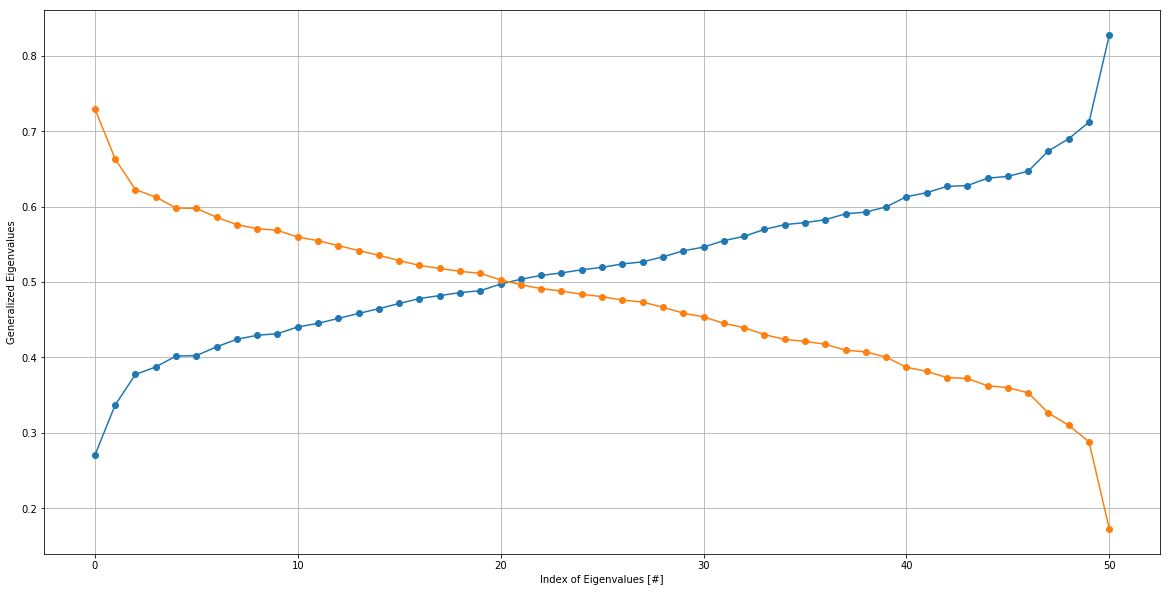

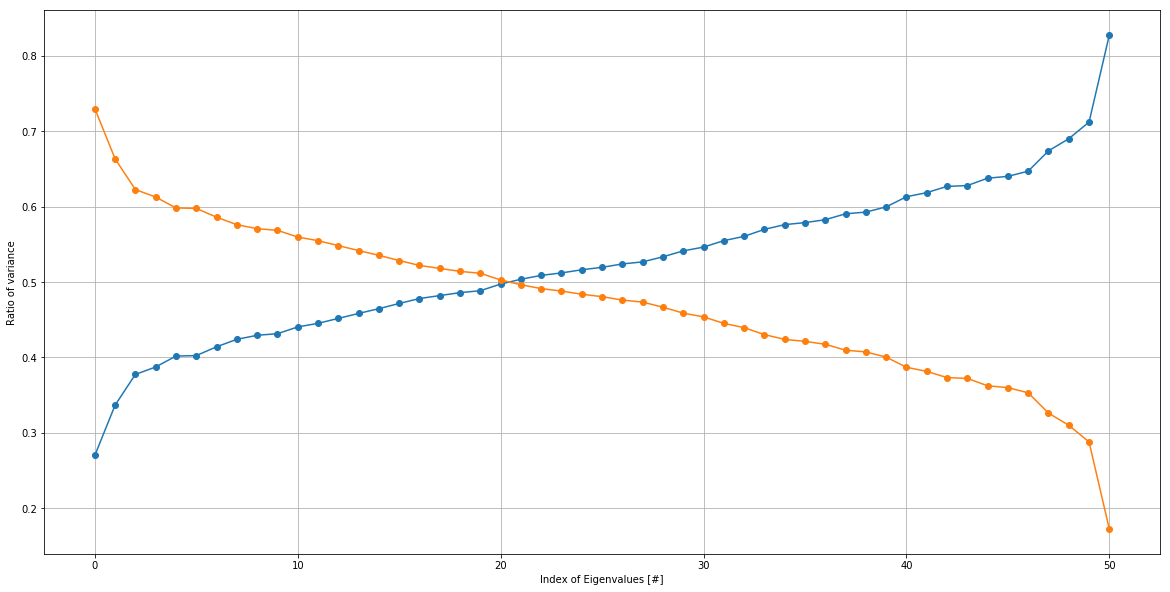

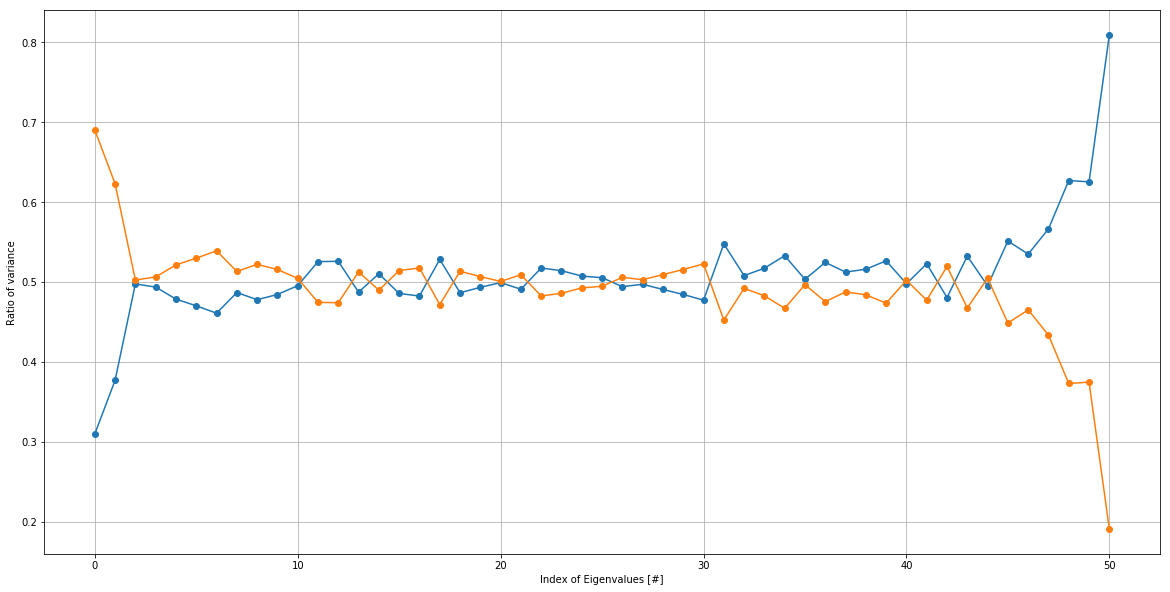

In [7]:
ival = [750, 4000]

#copy pasted from last sheet

ws = fs*2*np.pi
band = [((10.5*2*np.pi)/(.5*ws)), ((13.0*2*np.pi)/(.5*ws))]
b, a = sp.signal.butter(5, band, btype="bandpass")
Xf = sp.signal.lfilter(b,a,cnt)

epo, epo_t = bci.makeepochs(Xf, fs, mrk_pos, ival)

#Debugging
print("Xf shape:", Xf.shape)
print("Epo shape:", epo.shape)

#the only change: using half our data
W_half, d_half = train_CSP(epo[:,:,0:epo.shape[2]/2], mrk_class[0:mrk_class.shape[0]/2])
print("d shape:", d.shape)
print("W shape:", W.shape)

plt.figure(figsize=(20,10))
plt.plot(d_half, "-o")
#1-d: lecture 9 slide 16
plt.plot(1-d_half, "-o")
plt.grid()
plt.xlabel('Index of Eigenvalues [#]')
plt.ylabel('Generalized Eigenvalues')

#applying csp to our data and making epoch
csp_source = W_half.T.dot(Xf)
epo, epo_t = bci.makeepochs(csp_source, fs, mrk_pos, ival)

#calculating variance per channel and trial
var = np.var(epo,axis=0)
print("var shape",var.shape)
#var = np.log(var)

#seperating the variance to first and second half. there must be an easier way to do all this...
var_first = var[:,0:var.shape[1]/2]
var_second = var[:,var.shape[1]/2:var.shape[1]]

#avarage over clas 1, then class 2, then calculating what part of combined variance is class 0
avg_first_0 = np.average(var_first[:,mrk_class[0:var.shape[1]/2]==0], axis=1)
avg_first_1 = np.average(var_first[:,mrk_class[0:var.shape[1]/2]==1], axis=1)
avg_first = avg_first_0/(avg_first_0+avg_first_1)

avg_second_0 = np.average(var_second[:,mrk_class[var.shape[1]/2:]==0], axis=1)
avg_second_1 = np.average(var_second[:,mrk_class[var.shape[1]/2:]==1], axis=1)
avg_second = avg_second_0/(avg_second_0+avg_second_1)
print("avg first",avg_first.shape)

#yaaay, incorrectly labeled plots!!
plt.figure(figsize=(20,10))
plt.plot(avg_first, "-o")
#1-d: lecture 9 slide 16
plt.plot(1-avg_first, "-o")
plt.grid()
plt.xlabel('Index of Eigenvalues [#]')
plt.ylabel('Ratio of variance')

#since eigenvalues are percentage of variance per trial, it should be(and is) the same as eigenvalues
#second plot is, however, completely random.

plt.figure(figsize=(20,10))
plt.plot(avg_second, "-o")
#1-d: lecture 9 slide 16
plt.plot(1-avg_second, "-o")
plt.grid()
plt.xlabel('Index of Eigenvalues [#]')
plt.ylabel('Ratio of variance')

print("Since the eigenvalues represent the ratio of variance, calculating both on same data provides the same result. Calculating the ratio of variance on diffrent data is much diffrent, however.")

## Exercise 3: Classification using power spectral density features  (5 points)
Calculate the power spectral density (PSD, see sheet #07) in the interval 1000-5000 ms for all channels. Keep only the PSD values for the frequencies from 6 to 26 Hz. Concatenate those PSD values for all channels to obtain feature vectors. Estimate the performance of this classification approach using cross-validation.<br/>
Repeat the same procedure, this time applying the Laplace filter for selected channels (your choice, at least six) before calculating the PSD.

In [8]:
ival = [1000,5000]

epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)

epo = epo.transpose(1,2,0)

f, psd = sp.signal.welch(epo,fs=fs)

psd = psd[:,:,f>=6]
f = f[f>=6]
psd = psd[:,:,f<=26]
f = f[f<=26]

psd = psd.transpose(1,0,2)
psd = np.reshape(psd,(280,-1),order = 'C')
cfy.crossvalidation(cfy.train_LDA,psd.T,mrk_class,verbose=True)

 40.7 +/- 9.1  (training:  6.7 +/- 0.5)  [using train_LDA]


(40.742596799485341, 6.6553277896027598)

In [9]:
def proc_spatialFilter(cnt, clab, chan, neighbors='*'):
    '''
    Usage:
        cnt_sf = proc_spatialFilter(cnt, clab, chan, neighbors='*')
    Parameters:
        cnt:       a 2D array of multi-channel timeseries (size: channels x samples),
        clab:      a 1D array of channel names  (size: channels)
        chan:      channel of center location
        neighbors: labels of channels that are to be subtracted 
    Returns:
        cnt_sf:    timeseries of spatially filtered channel (size: 1 x samples)
    Examples:
        cnt_c4_bip = proc_spatialFilter(cnt, clab, 'C4', 'CP4')
        cnt_c4_lap = proc_spatialFilter(cnt, clab, 'C4', ['C2','C6','FC4','CP4'])
        cnt_c4_car = proc_spatialFilter(cnt, clab, 'C4', '*')
    '''
    cidx= clab.index(chan)
    if isinstance(neighbors, list):
        nidx = [clab.index(cc) for cc in neighbors]
    elif neighbors == '*':
        nidx = range(len(clab))   # Common Average Reference (CAR)
    else:
        nidx = [clab.index(neighbors)]
    cnt_sf = cnt[[cidx],:] - np.mean(cnt[nidx,:], axis=0)
    return cnt_sf

In [10]:
cnt_c4_lap = proc_spatialFilter(cnt, clab, 'C4', ['C2','C6','FC4','CP4'])
cnt_c3_lap = proc_spatialFilter(cnt, clab, 'C3', ['C1','C5','FC3','CP3'])
cnt_cp4_lap = proc_spatialFilter(cnt, clab, 'CP4', ['CP2','CP6','C4','P4'])
cnt_cp3_lap = proc_spatialFilter(cnt, clab, 'CP3', ['CP1','CP5','C3','P3'])
cnt_c2_lap = proc_spatialFilter(cnt, clab, 'C2', ['Cz','C4','FC2','CP2'])
cnt_c1_lap = proc_spatialFilter(cnt, clab, 'C1', ['Cz','C3','FC1','CP1'])

feature = np.array([cnt_c4_lap,cnt_c3_lap,cnt_cp4_lap,cnt_cp3_lap,cnt_c2_lap,cnt_c1_lap])

feature = feature.reshape(feature.shape[0],feature.shape[2])

epo, epo_t = bci.makeepochs(feature, fs, mrk_pos, ival)

epo = epo.transpose(1,2,0)

f, psd = sp.signal.welch(epo,fs=fs)

psd = psd[:,:,f>=6]
f = f[f>=6]
psd = psd[:,:,f<=26]
f = f[f<=26]

psd = psd.transpose(1,0,2)
psd = np.reshape(psd,(280,-1),order = 'C')

cfy.crossvalidation(cfy2.train_LDAshrink,psd.T,mrk_class,verbose=True)

 25.7 +/- 5.8  (training:  8.0 +/- 0.8)  [using train_LDAshrink]


(25.709211540093897, 7.9627217148351859)